In [1]:
# TODO:
# chekc whether might be useful, or of interest
# the following third party libraries
!pip install libsvm -q
!pip install pytablewriter -q

# TODO:
# check bugs about piq.spnr implemented code
# !pip install piq -q 

## Imports

In [2]:
from __future__ import print_function
from __future__ import division

# Standard Library, plus some Third Party Libraries
from pprint import pprint
from PIL import Image
from tqdm import tqdm
from typing import Union, Tuple

import copy
import datetime
import h5py
import math
import os
import random
import sys
import time
# import visdom

# Data Science and Machine Learning Libraries
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import numpy as np
import pandas as pd
import sklearn

from sklearn.model_selection import train_test_split

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# from piq import ssim
# from piq import psnr

# TorchVision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from torchvision.utils import save_image

import torchsummary

# skimage
import skimage
import skimage.metrics as skmetrics
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

In [3]:
print("Numpy Version: ", np.__version__)
print("Pandas Version: ", pd.__version__)
print("Sklearn Version: ", sklearn.__version__)
print("Sklearn Version: ", skimage.__version__)

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

Numpy Version:  1.18.5
Pandas Version:  1.1.2
Sklearn Version:  0.22.2.post1
Sklearn Version:  0.16.2
PyTorch Version:  1.6.0+cu101
Torchvision Version:  0.7.0+cu101


In [4]:
from google.colab import drive; drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup Notebook

### Set Seeds & Set Device

In [5]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
# Detect if we have a GPU available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = None
try:
    device = (torch.device('cuda:0') if torch.cuda.is_available()
        else torch.device('gpu'))
except:
    device = torch.device('cpu')
print(f"Training on device {device}.")
print(f"# cuda device: {torch.cuda.device_count()}")
if torch.cuda.device_count() > 0:
    print(f"Id current device: {torch.cuda.current_device()}")

Training on device cpu.
# cuda device: 0


### Globals

In [7]:
image_path = "/content/test001.png"

if os.path.exists('/content/outputs/') is False:
    os.makedirs('/content/outputs/')
elif os.path.isdir('/content/outputs/') is False:
    raise Exception("'/content/outputs/' should be output directory aimed at recording output results, from performed analysis!")

model_state_path = '/content/outputs/model.pth' # '../outputs/model.pth'
loss_image_path = '/content/outputs/loss.png' # '../outputs/loss.png'
psnr_image_path = '/content/outputs/psnr.png' # '../outputs/psnr.png'

### Functions

In [8]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [9]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [10]:
def psnr_custom(label, outputs, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    First we need to convert torch tensors to NumPy operable.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

In [11]:
def show_graphic_series_via_plot(
    series,
    image_path = "graphic_series.png", figsize=(10, 7),
    title = "Series Graphic",
    color='orange', label='data series',
    xlabel = 'pos', ylabel = 'value',
    show_min_max = False,
    ):

    plt.figure(figsize=figsize)
    if show_min_max is True:
        max_value = series.max()
        max_pos = series.argmax()
        plt.annotate(f"epoch = {max_pos:.0f} | val = {max_value:.3f}", (max_pos, max_value))
        # plt.annotate(f"epoch = {max_pos:.0f}", (max_pos, 0))
        plt.vlines(x = max_pos,  ymin = 0, ymax = max_value,  linestyles='dashed')


        middle_value = series[len(series)//2]
        middle_pos = len(series)//2
        plt.annotate(f"epoch = {middle_pos:.0f} | val {middle_value:.3f}", (middle_pos, middle_value))
        plt.vlines(x = middle_pos,  ymin = 0, ymax = middle_value,  linestyles='dashed')

        min_value = series.min()
        min_pos = series.argmin()
        plt.annotate(f"epoch = {min_pos:.0f} | val {min_value:.3f}", (min_pos, min_value))
        # plt.annotate(f"epoch = {min_pos:.0f}", (min_pos, 0))
        plt.vlines(x = min_pos,  ymin = 0, ymax = min_value,  linestyles='dashed')
        pass
    plt.plot(series, color=color, label=label)
    # plt.plot(val_loss, color='red', label='validataion loss')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(image_path)
    plt.show()
    pass

def show_graphic_series_via_ax(
    series,
    ax,
    image_path = "graphic_series.png", figsize=(10, 7),
    title = "Series Graphic",
    color='orange', label='data series',
    xlabel = 'pos', ylabel = 'value',
    show_min_max = False,
    ):

    if show_min_max is True:
        max_value = series.max()
        max_pos = series.argmax()
        ax.annotate(f"epoch = {max_pos:.0f} | val {max_value:.3f}", (max_pos, max_value))

        ax.vlines(x = max_pos,  ymin = 0, ymax = max_value,  linestyles='dashed')

        middle_value = series[len(series)//2]
        middle_pos = len(series)//2
        ax.annotate(f"epoch = {middle_pos:.0f} | val {middle_value:.3f}", (middle_pos, middle_value))
        ax.vlines(x = middle_pos,  ymin = 0, ymax = middle_value,  linestyles='dashed')

        min_value = series.min()
        min_pos = series.argmin()
        ax.annotate(f"epoch = {min_pos:.0f} | val {min_value:.3f}", (min_pos, min_value))

        ax.vlines(x = min_pos,  ymin = 0, ymax = min_value,  linestyles='dashed')
        pass

    ax.plot(series, color=color, label=label)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    pass

def show_graphic_series(
    series,
    image_path = "graphic_series.png", figsize=(10, 7),
    title = "Series Graphic",
    color='orange', label='data series',
    xlabel = 'pos', ylabel = 'value',
    ax = None,
    show_min_max = False,
    ):
    if ax is None:
        show_graphic_series_via_plot(
        series = series,
        image_path = image_path,
        title = title,
        figsize = figsize,
        color = color,
        label = label,
        xlabel = xlabel,
        ylabel = ylabel,
        show_min_max = show_min_max
    )
    else:
        show_graphic_series_via_ax(
        series = series,
        ax = ax,
        image_path = image_path,
        title = title,
        figsize = figsize,
        color = color,
        label = label,
        xlabel = xlabel,
        ylabel = ylabel,
        show_min_max = show_min_max
    )
    pass

def plot_series_graphic_by_config(series, config):
    show_graphic_series(
        series = series,
        image_path = config.image_path,
        title = config.title,
        figsize = config.figsize,
        color = config.color,
        label = config.label,
        xlabel = config.xlabel,
        ylabel = config.ylabel,
        ax = config.ax,
        show_min_max = config.show_min_max
    )
    pass

def plot_loss_graphic(loss_data, config):
    show_graphic_series(
        series = loss_data,
        image_path = config.image_path,
        title = config.title,
        figsize = config.figsize,
        color = config.color,
        label = config.label,
        xlabel = config.xlabel,
        ylabel = config.ylabel,
        show_min_max = config.show_min_max
    )
    pass

def plot_psnr_graphic(psnr_data, config):
    show_graphic_series(
        series = psnr_data,
        image_path = config.image_path,
        title = config.title,
        figsize = config.figsize,
        color = config.color,
        label = config.label,
        xlabel = config.xlabel,
        ylabel = config.ylabel,
        show_min_max = config.show_min_max
    )
    pass

### Classes

#### Config Class

In [12]:
class Config:  
    def __init__(self, **kwargs):
      for key, value in kwargs.items():
          setattr(self, key, value)
      pass
    pass

class PlotConfig(Config):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        pass
    pass

#### Data Loaders

In [13]:
# the dataset module
# TODO:
# not employed
class SirenDataset(Dataset):
    def __init__(self, image_data, labels):
        self.image_data = image_data
        self.labels = labels
    def __len__(self):
        return (len(self.image_data))
    def __getitem__(self, index):
        image = self.image_data[index]
        label = self.labels[index]
        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float))

# Currently used
class ImageFitting(Dataset):
    def __init__(self, sidelength, image_path = None):
        super().__init__()
        if image_path is None:
            img = get_cameraman_tensor(sidelength)
        else:
            imag = Image.open(image_path)
            imag = imag.resize((sidelength, sidelength))
            # printImageAttributes(imag, image_path)
            # imag = np.asarray(imag)
            transform = Compose([
                Resize(sidelength),
                ToTensor(),
                Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
            ])
            img = transform(imag)
            pass
        
        # print(type(img))
        # print(img.size())

        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)
        pass

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels
    pass

#### Siren Architecture

In [14]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

## Run Notebook

### Training and Validation Functions

In [15]:
def show_images_by_step_summary(step, loss, outputs):
    print("Step %d, Total loss %0.6f" % (step, loss))
    img_grad = gradient(outputs, coords)
    img_laplacian = laplace(outputs, coords)
    
    fig, axes = plt.subplots(1,3, figsize=(18,6))
    axes[0].imshow(outputs.cpu().view(256,256).detach().numpy())
    axes[1].imshow(img_grad.norm(dim=-1).cpu().view(256,256).detach().numpy())
    axes[2].imshow(img_laplacian.cpu().view(256,256).detach().numpy())
    plt.show()
    pass

# TODO:
# Wrong usage of show_image_flag
# right now, it is ineffective
def train(model, dataloader, criterion, optimizer, show_images_flag = False, step_til_summary = 10):
    # Activate train mode for input model
    model.train()

    # Accumulator variables to record metrics
    running_loss = 0.0
    running_psnr = 0.0
    running_ssim = 0.0

    # for bi, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
    for bi, data in enumerate(dataloader, 1):
        # Get batch of data
        image_data = data[0].to(device)
        label = data[1].to(device)
        
        # Compute forward pass
        optimizer.zero_grad()
        outputs, coords = model(image_data)    
        loss = criterion(outputs, label)

        # Compute and update additional metrics and eventually
        # show images
        if (show_images_flag == True) and (not bi % steps_til_summary):
            show_images_by_step_summary(bi, loss, outputs)
            pass
        
        # Metric: MSE
        # add loss of each item (total items in a batch = batch size)
        running_loss += loss.item()
        
        # Metric: PSNR
        # calculate batch psnr (once every `batch_size` iterations)
        # batch_psnr =  psnr(label, outputs)
        # running_psnr += batch_psnr
        # running_psnr += 10 * math.log10(1.0 / loss.item())
        # skmeasure.compare_psnr(
        # skmetrics.peak_signal_noise_ratio(
        batch_psnr = \
            psnr(
                outputs.cpu().view(256,256).detach().numpy(),
                label.cpu().view(256,256).detach().numpy(),
                data_range=1.0)
        running_psnr += batch_psnr

        # Metric: SSIM
        # skmetrics.structural_similarity(
        batch_mssim = \
            ssim(
                outputs.cpu().view(256,256).detach().numpy(),
                label.cpu().view(256,256).detach().numpy(),
                data_range=1.0)
        running_ssim += batch_mssim
        
        loss.backward()
        optimizer.step()
        pass

    # Redefine final metrics
    final_loss = running_loss / len(dataloader.dataset)
    # final_psnr = running_psnr/int(len(train_data)/dataloader.batch_size)
    final_psnr = running_psnr / len(dataloader.dataset)
    final_ssim = running_ssim / len(dataloader.dataset)

    # Return results from computation
    return final_loss, final_psnr, final_ssim

In [16]:
# TODO:
# validate function is not upated along with train

def validate(model, dataloader, epoch, criterion):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        # for bi, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        for bi, data in enumerate(dataloader):
            image_data = data[0].to(device)
            label = data[1].to(device)
            
            outputs = model(image_data)
            loss = criterion(outputs, label)
            # add loss of each item (total items in a batch = batch size) 
            running_loss += loss.item()
            # calculate batch psnr (once every `batch_size` iterations)
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr
        outputs = outputs.cpu()
        save_image(outputs, f"../outputs/val_sr{epoch}.png")
    
    
    final_loss = running_loss/len(dataloader.dataset)
    # final_psnr = running_psnr/int(len(train_data)/dataloader.batch_size)
    final_psnr = running_psnr/len(dataloader.dataset)
    return final_loss, final_psnr

In [17]:
def training_loop(model, train_loader, criterion, optimizer, verbose = 0):
    # TODO:
    # val_* - are currently not exploited, I will plan to use them
    # variables for keeping track of trainin and validation process
    train_loss, val_loss = [], []
    train_psnr, val_psnr = [], []
    train_ssim, val_ssim = [], []

    # TODO:
    # variable to be exploited with tensorboard if suppored by either current
    # notebook or script derived from the former
    # globaliter = 0
    

    start = time.time()
    # for epoch in range(epochs):
    for epoch in tqdm(range(epochs), total=epochs):
        if verbose == 1:
            print(f"Epoch {epoch + 1} of {epochs}")
        train_epoch_loss, train_epoch_psnr, train_epoch_ssim = train(model, train_loader, criterion, optimizer)

        # TODO:
        # not employed validation function
        # val_epoch_loss, val_epoch_psnr = validate(model, val_loader, epoch)

        if verbose == 1:
            print(f"Train Loss: {train_epoch_loss:.3f} | Train PSNR: {train_epoch_psnr:.3f} | Train SSIM: {train_epoch_ssim:.3f}")
            # print(f"Val Loss: {train_epoch_loss:.3f} | Val PSNR: {train_epoch_psnr:.3f} | Val SSIM: {train_epoch_ssim:.3f}")
            pass
    
        # TODO:
        # example of usage for globalizer
        # globaliter += 1

        train_loss.append(train_epoch_loss) # val_loss.append(val_epoch_loss)
        train_psnr.append(train_epoch_psnr) # val_psnr.append(val_epoch_psnr)
        train_ssim.append(train_epoch_ssim) # val_ssim.append(val_epoch_ssim)
        pass
    

    end = time.time()
    if verbose == 1:
        print(f"Finished training in: {((end-start)/60):.3f} minutes")

    # Create dictionary object containing history of the training / validation process
    # currently just training scores are recorded
    history_keys_list = 'train_loss;train_psnr;train_ssim'.split(";")
    history_values_list = [np.array(series) for series in [train_loss, train_psnr, train_ssim]]
    
    # Return results as plain python dictionary object
    history = dict(zip(history_keys_list, history_values_list))
    return model, history

### Fit Model

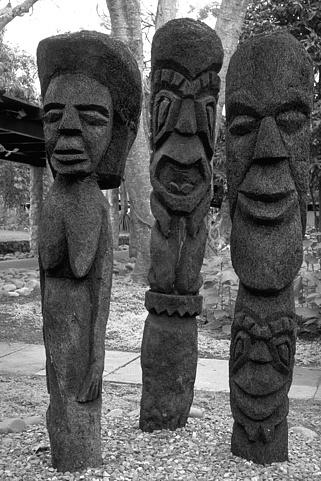

<Figure size 432x288 with 0 Axes>

In [18]:
plt.figure()
# im = Image.open(image_path).show()
# im.show()
Image.open(image_path)

In [19]:
# Hyper-params
lr = 1e-4
sidelenght = 256

epochs = 500

In [20]:
# Fetch Data
train_data = ImageFitting(sidelenght, image_path)
train_loader = DataLoader(train_data,
    batch_size=1,
    pin_memory=True,
    num_workers=0)

In [21]:
# Initialize the model
print('Computation device: ', device)
model = Siren(
    in_features = 2,
    hidden_features = sidelenght,
    hidden_layers = 5,
    out_features = 1,
    outermost_linear = True, 
    first_omega_0 = 30,
    hidden_omega_0 = 30.
).to(device)
print(model)

Computation device:  cpu
Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (5): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [22]:
# torchsummary.summary(model, input_size = (1, sidelenght, sidelenght), batch_size=-1, device = 'cuda')

In [23]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# loss function 
criterion = nn.MSELoss()

In [24]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
net.0.linear.weight 	 torch.Size([256, 2])
net.0.linear.bias 	 torch.Size([256])
net.1.linear.weight 	 torch.Size([256, 256])
net.1.linear.bias 	 torch.Size([256])
net.2.linear.weight 	 torch.Size([256, 256])
net.2.linear.bias 	 torch.Size([256])
net.3.linear.weight 	 torch.Size([256, 256])
net.3.linear.bias 	 torch.Size([256])
net.4.linear.weight 	 torch.Size([256, 256])
net.4.linear.bias 	 torch.Size([256])
net.5.linear.weight 	 torch.Size([256, 256])
net.5.linear.bias 	 torch.Size([256])
net.6.weight 	 torch.Size([1, 256])
net.6.bias 	 torch.Size([1])


In [25]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}]


In [26]:
model, history = training_loop(model, train_loader, criterion, optimizer, verbose = 0)

100%|██████████| 500/500 [57:12<00:00,  6.87s/it]


In [27]:
# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), model_state_path)

Saving model...


### Show Graphics

In [28]:
config_plot_loss = PlotConfig(
    image_path = loss_image_path,
    figsize = (10, 7),
    title = "Train - Loss vs Epochs",
    xlabel = "Epochs",
    ylabel = "Loss",
    label = "train loss",
    color = "orange",
    show_min_max = True,
    ax = None
)

config_plot_psnr = PlotConfig(
    image_path = psnr_image_path,
    figsize = (10, 7),
    title = "Train - PSNR (db) vs Epochs",
    xlabel = "Epochs",
    ylabel = "PSNR (db)",
    label = "train PSNR (db)",
    color = "green",
    show_min_max = True,
    ax = None
)

config_plot_ssim = PlotConfig(
    image_path = psnr_image_path,
    figsize = (10, 7),
    title = "Train - SSIM vs Epochs",
    xlabel = "Epochs",
    ylabel = "SSIM",
    label = "train SSIM",
    color = "red",
    show_min_max = True,
    ax = None
)

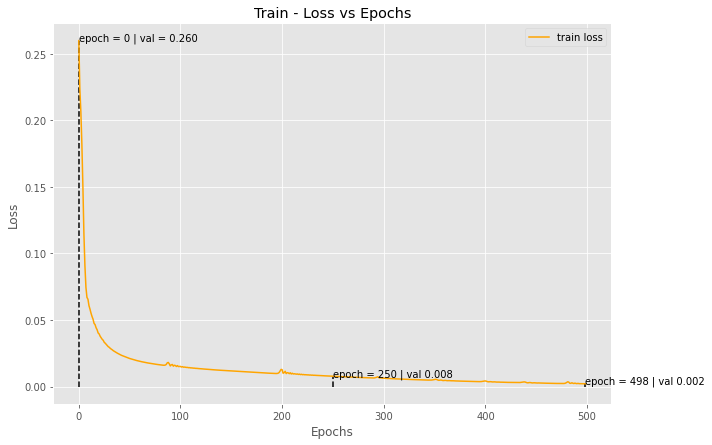

In [29]:
# plot_loss_graphic(loss_data = history['train_loss'], config = config_plot_loss)
plot_series_graphic_by_config(series = history['train_loss'], config = config_plot_loss)

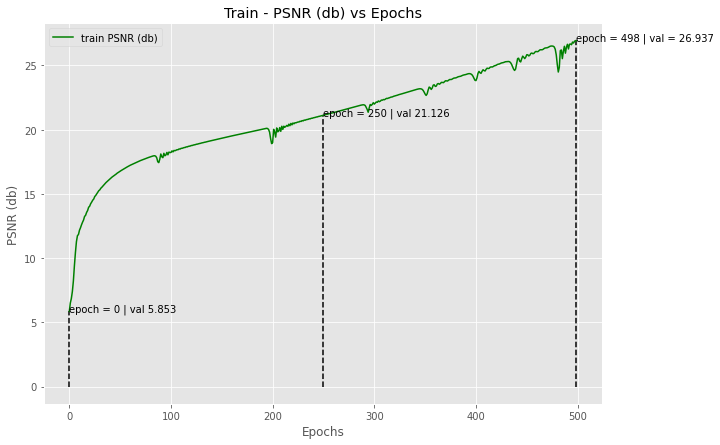

In [30]:
# plot_psnr_graphic(psnr_data = history['train_psnr'], config = config_plot_psnr)
plot_series_graphic_by_config(series = history['train_psnr'], config = config_plot_psnr)

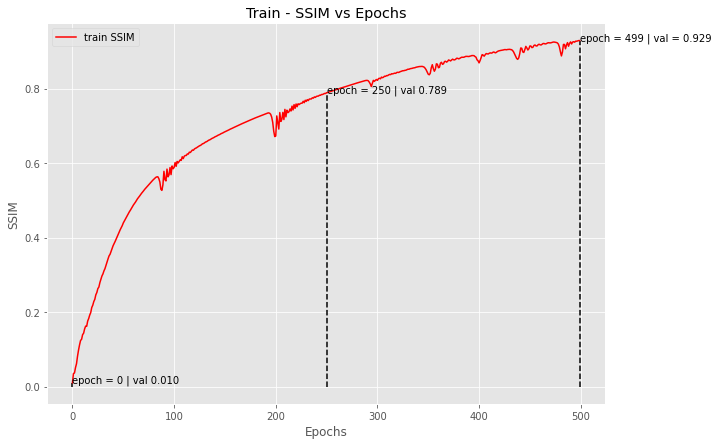

In [31]:
plot_series_graphic_by_config(history['train_ssim'], config_plot_ssim)

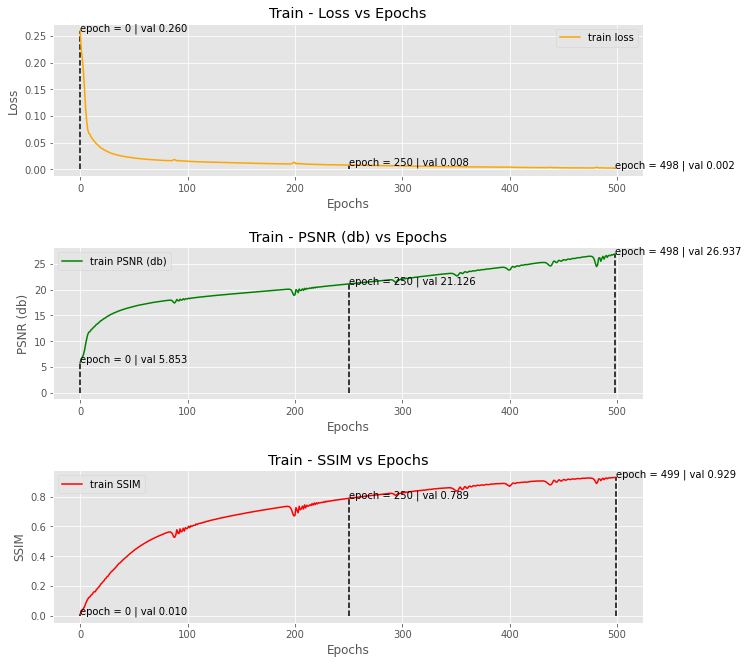

In [32]:
fig, axes = plt.subplots(3, figsize=(10, 10))
fig.tight_layout(pad=5.0) 

config_plot_loss.ax = axes[0]
config_plot_psnr.ax = axes[1]
config_plot_ssim.ax = axes[2]

plot_series_graphic_by_config(history['train_loss'], config_plot_loss)
plot_series_graphic_by_config(history['train_psnr'], config_plot_psnr)
plot_series_graphic_by_config(history['train_ssim'], config_plot_ssim)

### Evaluate against input data image

In [33]:
test_data = ImageFitting(sidelength = sidelenght, image_path = image_path)
test_loader = DataLoader(test_data,
    batch_size=1,
    pin_memory=True,
    num_workers=0)

test_data, ground_thruth = next(iter(test_loader))
test_data = test_data.to(device)

In [34]:
# Initialize the model
print('Computation device: ', device)
model = Siren(
    in_features = 2,
    hidden_features = sidelenght,
    hidden_layers = 3,
    out_features = 1,
    outermost_linear = True, 
    first_omega_0 = 30,
    hidden_omega_0 = 30.
).to(device)
print(model)

Computation device:  cpu
Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [36]:
model.load_state_dict(torch.load(model_state_path, map_location=device))
model.eval()

RuntimeError: ignored

In [ ]:
predicted_image, predicted_coords = model(test_data)

predicted_grad_image = gradient(predicted_image, predicted_coords)
predicted_laplacian_image = laplace(predicted_image, predicted_coords)

In [ ]:
# Metric: MSE
val_mse = \
    mean_squared_error(
        ground_thruth.cpu().view(sidelenght, sidelenght).detach().numpy(),
        predicted_image.cpu().view(sidelenght, sidelenght).detach().numpy())

# Metric: PSNR
val_psnr = \
    psnr(
        ground_thruth.cpu().view(sidelenght, sidelenght).detach().numpy(),
        predicted_image.cpu().view(sidelenght, sidelenght).detach().numpy(),
        data_range=1.0)

# Metric: SSIM
# skmetrics.structural_similarity(
val_mssim = \
    ssim(
        ground_thruth.cpu().view(sidelenght, sidelenght).detach().numpy(),
        predicted_image.cpu().view(sidelenght, sidelenght).detach().numpy(),
        data_range=1.0)

In [ ]:
image_name = os.path.basename(image_path)

data = np.array([val_mse, val_psnr, val_mssim])
columns = [f"predicted_{metric}" for metric in "mse;psnr;mssim".split(";")]

df_predicted_image = pd.DataFrame(data = [data], columns = columns, index = [image_name])
df_predicted_image.head(5)

In [ ]:
fig = plt.figure(figsize = (10, 9))

# build a rectangle in axes coords
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

msg = '\n'.join([f"{k}: {v:.4f}" for k, v in zip(df_predicted_image.columns, df_predicted_image.iloc[0,:])])
# print(msg)

ax = fig.add_subplot(111)
ax.text(256//2, 256//2, msg,
        # transform=ax.transAxes,
        fontsize=15,
        color='white',
        verticalalignment='bottom', horizontalalignment='right',)

plt.imshow(predicted_image.cpu().view(sidelenght, sidelenght).detach().numpy())
plt.savefig('/content/predicted_images.png')
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
fig.suptitle("Predicted Images")

axes[0].imshow(predicted_image.cpu().view(sidelenght, sidelenght).detach().numpy())
axes[0].set_title("Predicted Image")

axes[1].imshow(predicted_grad_image.norm(dim=-1).cpu().view(sidelenght, sidelenght).detach().numpy())
axes[1].set_title("Predicted Image Gradient")

axes[2].imshow(predicted_laplacian_image.cpu().view(sidelenght, sidelenght).detach().numpy())
axes[2].set_title("Predicted Image Laplacian")

plt.savefig('/content/complex_predicted_images.png')
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("Comparing Ground Thruth vs. Predicted Images")

axes[0, 0].imshow(Image.open(image_path))
axes[0, 0].set_title("Ground Thruth Image")

axes[0, 1].imshow(predicted_image.cpu().view(sidelenght, sidelenght).detach().numpy())
axes[0, 1].set_title("Predicted Image")

axes[1, 0].imshow(predicted_grad_image.norm(dim=-1).cpu().view(sidelenght, sidelenght).detach().numpy())
axes[1, 0].set_title("Predicted Image Gradient")

axes[1, 1].imshow(predicted_laplacian_image.cpu().view(sidelenght, sidelenght).detach().numpy())
axes[1, 1].set_title("Predicted Image Laplacian")

plt.savefig('/content/complex_ground_thruth_vs_predicted.png')
plt.show()

## References

- Pytorch Reference's Manual:
 - [SAVING AND LOADING MODELS](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 - [torch.nn module](https://pytorch.org/docs/stable/nn.html)
 - [TensorBoard Support](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)
 - [Train Example](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#model-training-and-validation-code)
 - [PSNR - Pytorch Example](https://github.com/pytorch/examples/blob/master/super_resolution/main.py#L70)
 - [TORCH.OPTIM](https://pytorch.org/docs/stable/optim.html)

- Initialization Topic (Papers):
  - [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) by X. Glorot & Y.Bengio, which lead to default Pytorch's weights initialization knwon as *Xavier initialization* algorithm or scheme
 -  [Fixup Initialization: Residual Learning Without Normalization](https://arxiv.org/abs/1901.09321) by Hongyi Zhang, Yann N. Dauphin, Tengyu Ma, whose works allows to *get rid off batch normalization layers* with a given particular NN Arch, to still be able to train a NN arch with meaningful and confident results or performance.

- Activation Functions (Papers):
  - [Deep Learning using Rectified Linear Units (ReLU)](https://arxiv.org/pdf/1803.08375.pdf)

- Datasets:
  - [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)

- Regularization techniques (Papers):
  - [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shif](https://arxiv.org/abs/1502.03167)
  - [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)

- Archs Types (Papers):
  - [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
  - [Densely Connected Convolutional Networks](https://arxiv.org/abs/1608.06993)
  - [Highway Networks
](https://arxiv.org/pdf/1505.00387.pdf)
  - [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

- Some Third Party useful Tutorials:
 - [Imagenet example](https://github.com/pytorch/examples/blob/master/imagenet/main.py#L327)
 - [Writing a better code with pytorch and einops](https://arogozhnikov.github.io/einops/pytorch-examples.html)
 - [Hands-on Graph Neural Networks with PyTorch & PyTorch Geometric - MEDIUM](https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8)
 - [Pytorch Example](https://pythonprogramming.net/analysis-visualization-deep-learning-neural-network-pytorch/)
 - [Image Super-Resolution using Deep Learning and PyTorch](https://debuggercafe.com/image-super-resolution-using-deep-learning-and-pytorch/)
 - [python-data](https://exeter-data-analytics.github.io/python-data/)

- Books
  - [List of books for improving Pytorch knowledge](https://bookauthority.org/books/best-pytorch-books)

- GitHub Projetcs:
  - [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric)
  - [Minetorch](https://github.com/minetorch/minetorch)
  - [Pierogi](https://github.com/nalepae/pierogi/)
  - [Visdom](https://github.com/facebookresearch/visdom#vismatplot)
  - [drawnow for matplotlib](https://github.com/stsievert/python-drawnow)

- Tensorboard:
  - [A Quickstart Guide to TensorBoard](https://towardsdatascience.com/a-quickstart-guide-to-tensorboard-fb1ade69bbcf)
  - [How to use Tensorboard with PyTorch in Google Colab](https://medium.com/looka-engineering/how-to-use-tensorboard-with-pytorch-in-google-colab-1f76a938bc34)
  - [VISUALIZING MODELS, DATA, AND TRAINING WITH TENSORBOARD](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)